# Learning temporal data with variational quantum recurrent neural network

## Student Names: Jason Bai, Jane Shi, Eva Wang, Bobby Zou

Note: Our repo does not have many commits because we always worked together in-person, 
every team member contributed evenly to the workload.

In [1]:
import pennylane as qml
from pennylane import numpy as np

import matplotlib.pyplot as plt

# recommended by prof, to control update to training parameters during Gradient Descent 
from pennylane.math.utils import requires_grad

In [2]:
# Initialize devices for qubits.
# 
# Second device is for implementing the measure-and-reset functionality from the paper.
# Pennylane does not have a feature for resetting a wire in the middle of execution, 
# so this second device is used as a workaround.
#
# Wires 0,1,2 are Group B (input training data).
# Wires 3,4,5 are Group A (store past data).
#
# The 2 devices go through the same operations, only difference is that
# one device returns the density matrix for re-initializing Group A qubits after measure-and-reset,
# the other device return expectation value for calculating loss and updating training parameters.

dev1 = qml.device("default.mixed", wires=6)
dev2 = qml.device("default.mixed", wires=6)


# Initialize a, J values (stays same throughout training).
a = []
J = np.zeros((6, 6))
for i in range(6):
  a.append( np.random.uniform(-1.0, 1.0) )
  for j in range(i):
    J[i][j] = np.random.uniform(-1.0, 1.0)

# Calculate Hint (Hamiltonian used for evolving the circuit).
coeffs = []
obs = []
for j in range(6):
    coeffs.append(a[j])
    obs.append(qml.PauliX(j))
    for k in range(j):
      coeffs.append(J[j][k])
      obs.append(qml.PauliZ(j) @ qml.PauliZ(k))
Hint = qml.Hamiltonian(coeffs, obs)

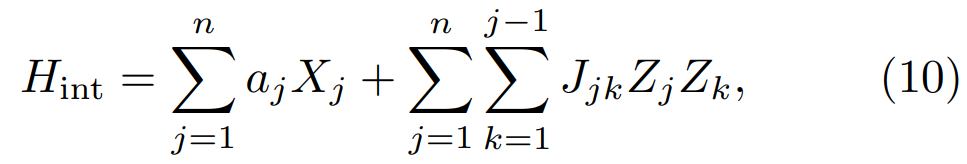

In [3]:
# Some constant values (as specified in paper).
D = 3
tau = 0.2

# Flag for checking if current iteration is the first. 
# If so, then density matrix for re-initializing Group A qubits will not need to be used. 
is_First_Iteration = np.array(1, requires_grad=False)

# Initialize density matrix, updated after each iteration
prev_state = np.zeros(12, requires_grad=False)

# Training parameters (initialized to 0 or 1, as specified in the paper).
alpha_array = np.zeros((D, 6))
beta_array  = np.zeros((D, 6))
gamma_array = np.zeros((D, 6))
c = np.asarray(1.0)

# Encoding Step of the circuit.
def encoding(x):
    qml.RY(np.arccos(x), wires=0)
    qml.RY(np.arccos(x), wires=1)
    qml.RY(np.arccos(x), wires=2)

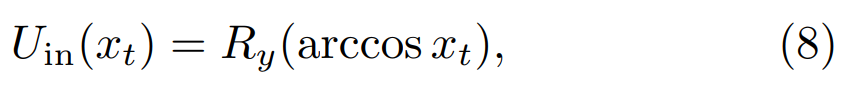

In [4]:
# Used to implement Evolution Step of the circuit.
def U1(alpha, beta, gamma, wire):
     qml.RX(alpha, wires=wire)
     qml.RZ(beta, wires=wire)
     qml.RX(gamma, wires=wire)

# Evolution Step of the circuit.
def evolution(alpha_array, beta_array, gamma_array):
    for i in range (D): # D = 3
        # U1 rotations
        for j in range(6):
            U1(alpha_array[i][j], beta_array[i][j], gamma_array[i][j], j)

        # np.exp(-1.0*j * Hint * tau) # e^(-i Hint tau)
        #change third paramter (larger is more accurate)
        qml.ApproxTimeEvolution(Hint, tau, 1)

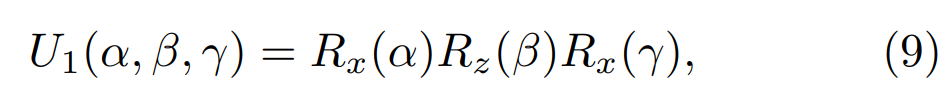

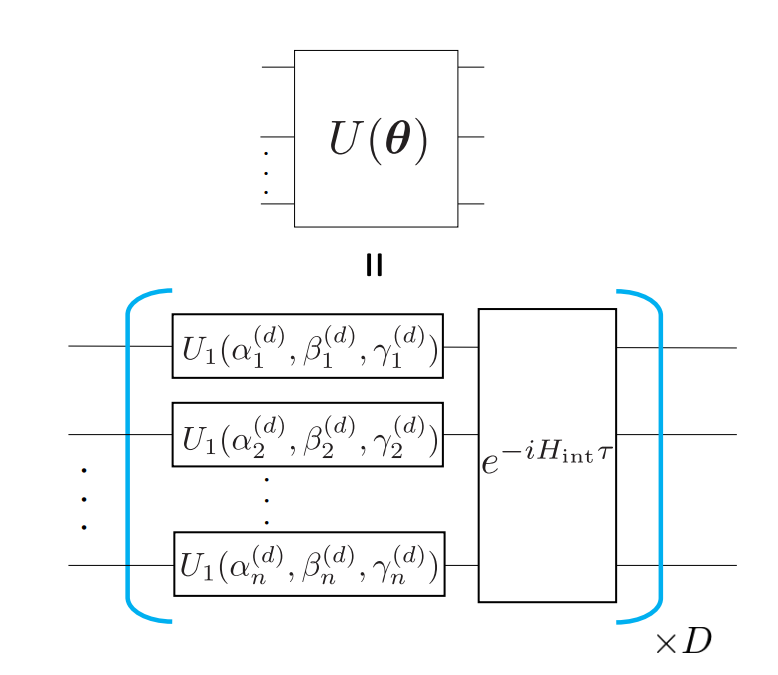

(<Figure size 1600x700 with 1 Axes>, <Axes:>)


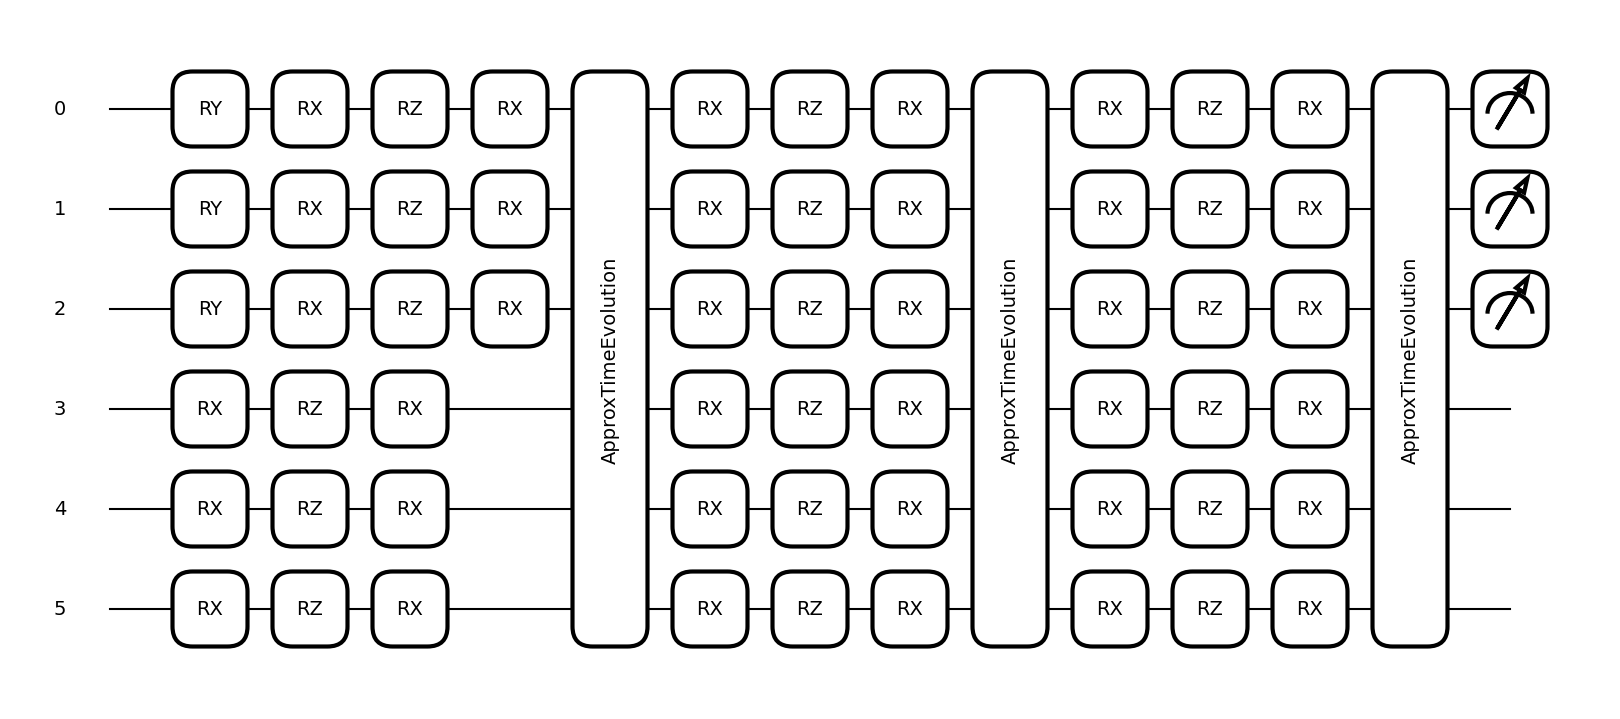

In [5]:
# Function that returns expectation value for use in first device only.
@qml.qnode(dev1)
def pqc_expval(x, alpha_array, beta_array, gamma_array, prev_state, is_First_Iteration):

    if (is_First_Iteration == 0):
        qml.QubitDensityMatrix(state_vector=prev_state, wires=[3,4,5])

    if (is_First_Iteration == 1):
        is_First_Iteration = 0
    
    encoding(x)
    evolution(alpha_array, beta_array, gamma_array)

    return [qml.expval(qml.PauliZ(i)) for i in range(3)]


# Function that returns density matrix for use in second device only.
@qml.qnode(dev2)
def pqc_state(x, alpha_array, beta_array, gamma_array, prev_state, is_First_Iteration):

    if (is_First_Iteration == 0):
        qml.QubitDensityMatrix(state_vector=prev_state, wires=[3,4,5])

    if (is_First_Iteration == 1):
        is_First_Iteration = 0
    
    encoding(x)
    evolution(alpha_array, beta_array, gamma_array)
    
    return qml.density_matrix(wires=[3,4,5])

# Run previous 2 functions.
# Captures density matrix from second device, 
# and plugs into both devices for re-initialization after measure-and-reset.
def timestep_output(x, alpha_array, beta_array, gamma_array, c, prev_state, is_First_Iteration):
    
    result = pqc_expval(x, alpha_array, beta_array, gamma_array, prev_state, is_First_Iteration)
    prev_state = pqc_state(x, alpha_array, beta_array, gamma_array, prev_state, is_First_Iteration)

    y = c * (( result[0] + result[1] + result[2] ) / 3.0)

    return y

print(qml.draw_mpl(pqc_expval)(0.5, alpha_array, beta_array, gamma_array, prev_state, is_First_Iteration))

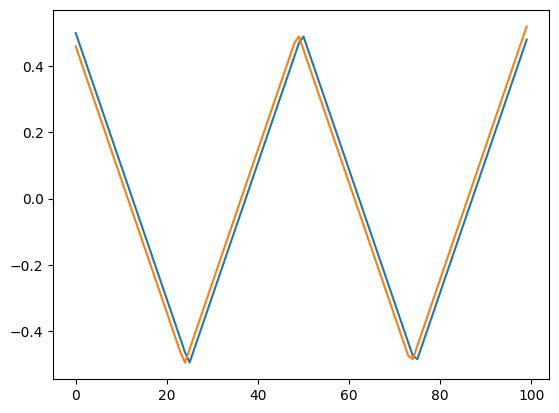

In [6]:
# function for generating training data (triangular wave version)
def generate_input_triangular(t_in):
    t = 8/199 * t_in
    if t >= 0 and t <= 1:
        return -t + 0.5
    elif t >= 1 and t <= 2:
        return t - 1.5
    elif t >= 2 and t <= 3:
        return -t + 2.5
    else:
        return t - 3.5

train_inputs_triangular = []
train_expected_outputs_triangular = []

for i in range(100):
    train_inputs_triangular.append(generate_input_triangular(i))
    train_expected_outputs_triangular.append(generate_input_triangular(i+1))

plt.plot(train_inputs_triangular)
plt.plot(train_expected_outputs_triangular)

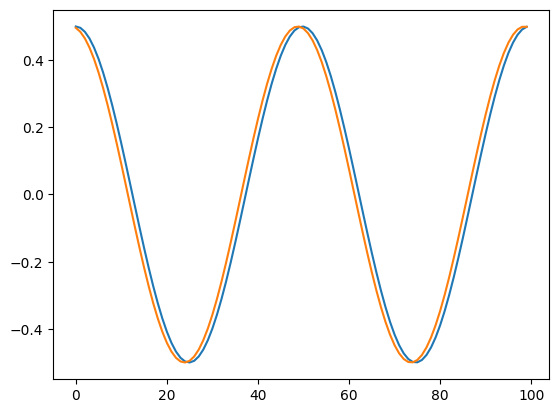

In [7]:
# function for generating training data (cosine wave version)
def generate_input_cosine(t_in):
    t = 8/199 * t_in
    return np.cos(np.pi * t) / 2.0

train_inputs_cosine = []
train_expected_outputs_cosine = []

for i in range(100):
    train_inputs_cosine.append(generate_input_cosine(i))
    train_expected_outputs_cosine.append(generate_input_cosine(i+1))

plt.plot(train_inputs_cosine)
plt.plot(train_expected_outputs_cosine)

In [8]:
# Adapted from Lecture 8 Demo helper functions, 
# changed to use our training parameters instead.

# Predict the labels of all points in a data set for a given model.
def make_predictions(data, model, alpha_array, beta_array, gamma_array, c, prev_state, is_First_Iteration):

    preds = []
    
    for idx in range(len(data)):
        estimated_expval = model(data[idx], alpha_array, beta_array, gamma_array, c, prev_state, is_First_Iteration)
        
        preds.append(estimated_expval)
            
    return preds


def make_loss_function(data, labels, model):

    def loss(alpha_array, beta_array, gamma_array, c, prev_state, is_First_Iteration):
        loss_sum = 0.0

        for idx in range(len(data)):
            point = data[idx]
            true_expval = labels[idx]

            estimated_expval = model(point, alpha_array, beta_array, gamma_array, c, prev_state, is_First_Iteration)
            loss_sum += (estimated_expval - true_expval) ** 2

        return loss_sum / len(data)
    
    return loss

# Compute the accuracy of our predictions.
def compute_accuracy(predictions, true_labels):
        
    n_samples = len(predictions)
    
    return np.sum(
        [np.abs(predictions[x]-true_labels[x]) < 0.1 for x in range(n_samples)
    ]) / n_samples

In [9]:
loss_triangular = make_loss_function(train_inputs_triangular, train_expected_outputs_triangular, timestep_output)
loss_cosine = make_loss_function(train_inputs_cosine, train_expected_outputs_cosine, timestep_output)

In [10]:
# Enable ...
# gradient_function = qml.grad(timestep_output)

In [11]:
# Train parameters and run model for 100 iterations. 
# (Triangular wave version)

opt = qml.GradientDescentOptimizer(stepsize=0.1)

n_its = 100

loss_track = []

for it in range(n_its):
    (alpha_array, beta_array, gamma_array, c, prev_state, is_First_Iteration), _loss = opt.step_and_cost(loss_triangular, alpha_array, beta_array, gamma_array, c, prev_state, is_First_Iteration)

    if it % 5 == 0:
        our_preds_triangular = make_predictions(train_inputs_triangular, timestep_output, alpha_array, beta_array, gamma_array, c, prev_state, is_First_Iteration)
        print(f"Loss at iteration {it} = {_loss}  Accuracy = {compute_accuracy(our_preds_triangular, train_expected_outputs_triangular)}")
    loss_track.append(_loss)

Loss at iteration 0 = 0.02764348850865214  Accuracy = 0.3
Loss at iteration 5 = 0.00952607603781908  Accuracy = 0.72
Loss at iteration 10 = 0.004630055264676943  Accuracy = 0.84
Loss at iteration 15 = 0.0031288031126723696  Accuracy = 0.94
Loss at iteration 20 = 0.0025844706344291674  Accuracy = 0.99
Loss at iteration 25 = 0.0023289775538782357  Accuracy = 1.0
Loss at iteration 30 = 0.0021723344308749886  Accuracy = 1.0
Loss at iteration 35 = 0.002058397114746726  Accuracy = 1.0
Loss at iteration 40 = 0.0019689419051168444  Accuracy = 1.0
Loss at iteration 45 = 0.001896712498572332  Accuracy = 1.0
Loss at iteration 50 = 0.001837850200431715  Accuracy = 1.0
Loss at iteration 55 = 0.001789748305607536  Accuracy = 1.0
Loss at iteration 60 = 0.001750413709410592  Accuracy = 1.0
Loss at iteration 65 = 0.0017182479335312775  Accuracy = 1.0
Loss at iteration 70 = 0.0016919486793319522  Accuracy = 1.0
Loss at iteration 75 = 0.001670450118430858  Accuracy = 1.0
Loss at iteration 80 = 0.00165287

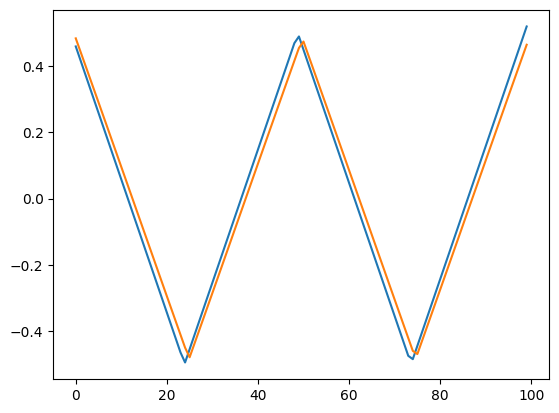

In [12]:
# Plot results after 100 iterations (Triangular wave version).
plt.plot(train_expected_outputs_triangular)
plt.plot(our_preds_triangular)

In [15]:
# Re-initialize trainable parameters, prev_state, 
# and is_First_Iteration flag for new run with cosine wave.

# Flag for checking if current iteration is the first. 
# If so, then density matrix for re-initializing Group A qubits will not need to be used. 
is_First_Iteration = np.array(1, requires_grad=False)

# Initialize density matrix, updated after each iteration
prev_state = np.zeros(12, requires_grad=False)

# Training parameters (initialized to 0 or 1, as specified in the paper).
alpha_array = np.zeros((D, 6))
beta_array  = np.zeros((D, 6))
gamma_array = np.zeros((D, 6))
c = np.asarray(1.0)

In [16]:
# Train parameters and run model for 100 iterations. 
# (Cosine wave version)

opt = qml.GradientDescentOptimizer(stepsize=0.1)

n_its = 100

loss_track = []

for it in range(n_its):
    (alpha_array, beta_array, gamma_array, c, prev_state, is_First_Iteration), _loss = opt.step_and_cost(loss_cosine, alpha_array, beta_array, gamma_array, c, prev_state, is_First_Iteration)

    if it % 5 == 0:
        our_preds_cosine = make_predictions(train_inputs_cosine, timestep_output, alpha_array, beta_array, gamma_array, c, prev_state, is_First_Iteration)
        print(f"Loss at iteration {it} = {_loss}  Accuracy = {compute_accuracy(our_preds_cosine, train_expected_outputs_cosine)}")
    loss_track.append(_loss)

Loss at iteration 0 = 0.02817806186422016  Accuracy = 0.39
Loss at iteration 5 = 0.010562918728272324  Accuracy = 0.6
Loss at iteration 10 = 0.005395922084154497  Accuracy = 0.77
Loss at iteration 15 = 0.003667592695570529  Accuracy = 1.0
Loss at iteration 20 = 0.002986310660066756  Accuracy = 1.0
Loss at iteration 25 = 0.002654316496897104  Accuracy = 1.0
Loss at iteration 30 = 0.0024577662900966478  Accuracy = 1.0
Loss at iteration 35 = 0.0023261454482260318  Accuracy = 1.0
Loss at iteration 40 = 0.002232605157663559  Accuracy = 1.0
Loss at iteration 45 = 0.00216448027131356  Accuracy = 1.0
Loss at iteration 50 = 0.0021144071326127676  Accuracy = 1.0
Loss at iteration 55 = 0.002077484800950058  Accuracy = 1.0
Loss at iteration 60 = 0.00205023299956556  Accuracy = 1.0
Loss at iteration 65 = 0.0020301149809339976  Accuracy = 1.0
Loss at iteration 70 = 0.0020152641763513065  Accuracy = 1.0
Loss at iteration 75 = 0.0020043029032416845  Accuracy = 1.0
Loss at iteration 80 = 0.001996213500

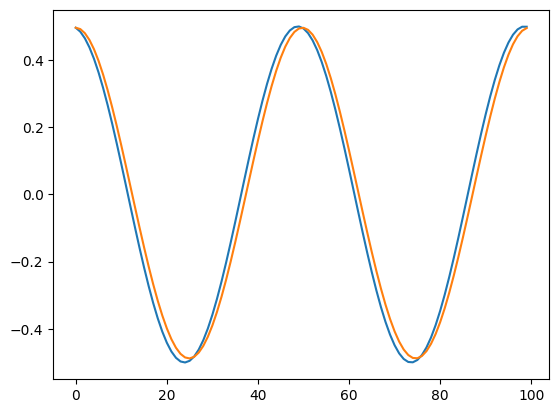

In [ ]:
# Plot results after 100 iterations (Cosine wave version).
plt.plot(train_expected_outputs_cosine)
plt.plot(our_preds_cosine)